In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as stats
import scanpy as sc
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import os

In [23]:
full_df = pd.read_csv('cross_tissue_expression.gz.csv', index_col=0)

/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [24]:
def fisher_coexp(gene1_vec, gene2_vec):
    if gene1_vec.any() and gene2_vec.any():
        tbt = pd.crosstab(gene1_vec, gene2_vec)
        odds, pv = stats.fisher_exact(tbt)
    else:
        odds = np.nan
        pv = np.nan
    return odds, np.log10(odds), pv, np.log10(pv)

# function definitions

In [25]:
def plot_freq_by_class(dataframe, plot_field, class_order, filepath=None, xlabel=None, title=None, pseudo_count=True, dpi=400, log=True, marker='o', ax=None):
    
    ### calcuate a few important parameters
    # add pseudocounts
    if pseudo_count and ('pseudo' not in plot_field):
        pseudo_count = dataframe[plot_field][dataframe[plot_field]>0].min()/2
        dataframe[plot_field + '_pseudo'] = dataframe[plot_field] + pseudo_count
        plot_field = plot_field + '_pseudo'
    
    # medians
    medians = dataframe.groupby('manual_cell_type')[plot_field].median()
    
    # number of classes plotted
    num_classes = len(medians)
    
    # boolean of tissues included
    tissue_included = [tissue in dataframe.tissue.unique()for tissue in tissue_order]
    
    if not ax:
        fig,ax=plt.subplots(figsize=(5,4))
        
    sns.stripplot(y='manual_cell_type', 
                  x=plot_field, 
                  hue='tissue', 
                  data=dataframe, 
                  size=6, 
                  jitter=.3, 
                  palette=colors[tissue_included], 
                  marker=marker, 
                  order=class_order,
                  ax=ax)
    
    #pdb.set_trace()
    #ax.legend_.remove()

    plt.ylabel('');
    
    # if xlabel is specified, add it
    if xlabel:
        plt.xlabel(xlabel)
    # add title if specified
    if title:
        ax.set_title(title)
    
    # add median lines
    plt.vlines(medians[class_order], ymin=np.arange(num_classes)-.4, ymax=np.arange(num_classes)+.4, linewidth=.5, color=(.2, .2, .2))
    
    # set axis scales and limits
    if log:
        ax.set_xscale('log')
    #ax.set_ylim(num_classes + .5, -.5);
    ax.set_xlim(pseudo_count, ax.get_xlim()[1]); 
    ax.yaxis.tick_right()
    
    # format ticks
    figure = ax.get_figure()
    #ax.grid('on', axis='y', alpha=1, lw=.5, c="k")     
    ax.grid('on', axis='y', alpha=1, lw=.5, c=(.8, .8, .8))    
    
    ax.xaxis.set_major_formatter(ScalarFormatter())

    # print and save figure
    plt.tight_layout()  
    if filepath:
        figure.savefig(os.path.join(filepath, 'ACE2+' + plot_field + '+_frequency_cell_class' + '.pdf'))
        figure.savefig(os.path.join(filepath, 'ACE2+' + plot_field + '+_frequency_cell_class' + '.png'), dpi=dpi)
    return ax

In [26]:
def plot_freq_by_tissue(dataframe, plot_field, tissue2n, tissue_order, filepath=None, xlabel=None, title=None, pseudo_count=1e-2, dpi=400, log=True, marker='o', ax=None):
    
    ### calcuate a few important parameters
    # add pseudocounts
    if pseudo_count and ('pseudo' not in plot_field):
        dataframe[plot_field + '_pseudo'] = dataframe[plot_field] + pseudo_count
        plot_field = plot_field + '_pseudo'
    
    # medians
    medians = dataframe.groupby('tissue')[plot_field].median()
    #medians = medians.reindex(dataframe.tissue.dropna().unique())
    
    # number of tissues plotted
    num_tissues = len(medians)
    
    if not ax:
        fig,ax=plt.subplots(figsize=(5,4))
        
    sns.stripplot(y='tissue', 
                  x=plot_field, 
                  hue='tissue', 
                  data=dataframe, 
                  size=3, 
                  jitter=.3, 
                  ax=ax, 
                  palette=colors, 
                  marker=marker, 
                  order=tissue_order)
    ax.legend_.remove()

    # remove underscores from labels
    no_underscore_labels = []
    for i,item in enumerate(ax.get_yticklabels()):
        no_underscore_labels.append(item.get_text().replace('_', ' ') + 
                                ' (n=' + 
                                str(tissue2n[item.get_text()]) + ')')        

    plt.yticks(ax.get_yticks(), no_underscore_labels);
    plt.ylabel('');
    
    # if xlabel is specified, add it
    if xlabel:
        plt.xlabel(xlabel)
    # add title if specified
    if title:
        ax.set_title(title)
    
    # add median lines
    plt.vlines(medians, ymin=np.arange(21)-.4, ymax=np.arange(21)+.4, linewidth=.5, color=(.2, .2, .2))
    
    # set axis scales and limits
    if log:
        ax.set_xscale('log')
    ax.set_ylim(num_tissues + .5, -.5);
    ax.set_xlim(pseudo_count, ax.get_xlim()[1]); 
    ax.yaxis.tick_right()
    
    # format ticks
    figure = ax.get_figure()
    #ax.grid('on', axis='y', alpha=1, lw=.5, c="k")     
    ax.grid('on', axis='y', alpha=1, lw=.5, c=(.8, .8, .8))    
    
    ax.xaxis.set_major_formatter(ScalarFormatter())

    # print and save figure
    plt.tight_layout()  
    if filepath:
        figure.savefig(os.path.join(filepath, plot_field + '.pdf'))
        figure.savefig(os.path.join(filepath, plot_field + '.png'), dpi=dpi)
    return ax


### important constants

In [27]:
#tissue order
tissue_order = pd.concat((full_df[['study', 'sample', 'tissue']], (full_df['ACE2']>0) & (full_df['TMPRSS2']>0)), axis=1).groupby(['study', 'sample', 'tissue']).mean().reset_index().groupby('tissue')[0].max().sort_values(ascending=False).index.to_list()

# tissue2n
tissue2n = full_df.groupby(['study', 'sample', 'tissue']).size().reset_index()['tissue'].value_counts().to_dict()

# plotting colors
colors = np.array([(164, 211, 238),
                   (132, 160, 209),
                   (23, 61, 224),
                   (32, 170, 17),
                   (154, 216, 35),
                   (115, 249, 169),
                   (237, 114, 3),
                   (251, 176, 64),
                   (232, 207, 56),
                   (190, 30, 45),
                   (174, 157, 49),
                   (247, 77, 86),
                   (142, 142, 142),
                   (217, 217, 217),
                   (38, 172, 247),
                   (205, 183, 158),
                   (102, 194, 165),
                   (166, 86, 40),
                   (231, 138, 195),
                   (146, 39, 143),
                   (102, 45, 145)])/255    

# show expression rate for every gene and relevant double positives

In [28]:
full_df['tissue'] = pd.Categorical(full_df['tissue'], ordered=True, categories=tissue_order)

In [29]:
gene_names = full_df[full_df.columns[5:-1]].columns
type_dict = {gene:'bool' for gene in gene_names}

In [30]:
mean_df = full_df.astype(type_dict).groupby(['study', 'sample', 'tissue'], observed=True).mean().reset_index()

### single gene frequencies

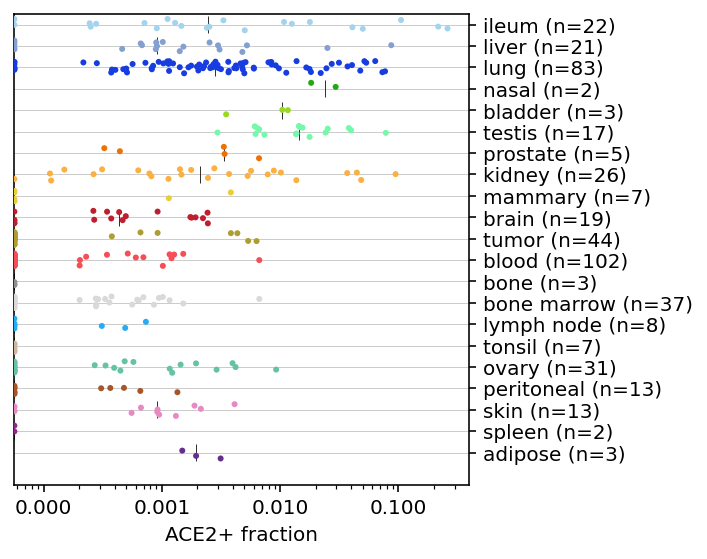

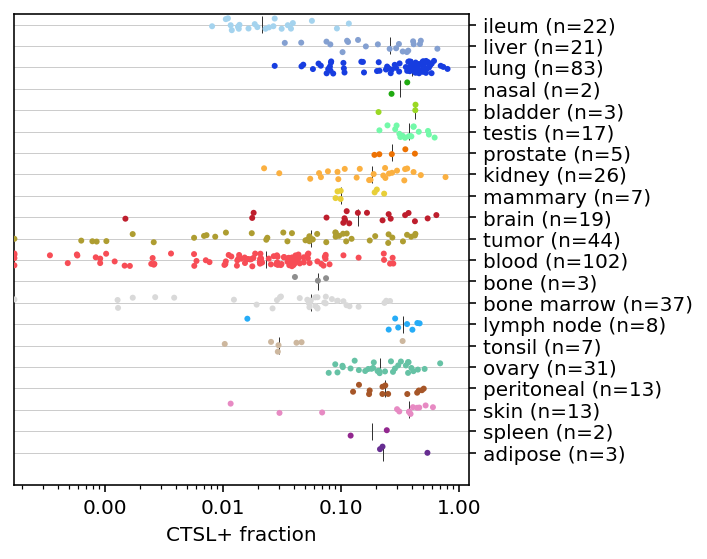

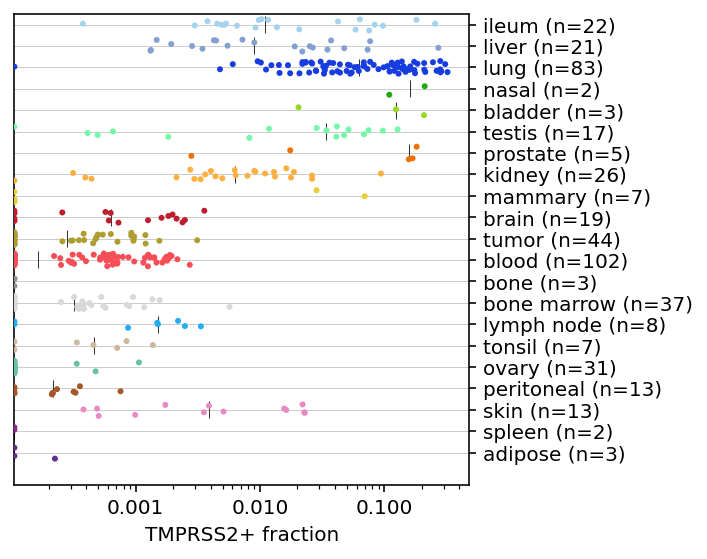

In [31]:
for gene in ['ACE2', 'CTSL', 'TMPRSS2']:
    min_val = mean_df[gene][mean_df[gene]>0].min()
    plot_freq_by_tissue(mean_df, gene, tissue2n, tissue_order, pseudo_count=min_val, xlabel= gene + '+ fraction')


### double positives

In [32]:
co_express_genes = ['CTSL', 'TMPRSS2']

ace2_inds = full_df['ACE2']>0
ace2_df = pd.concat([ace2_inds]*len(co_express_genes), axis=1)

In [33]:
dp_df = pd.DataFrame(data=(full_df[co_express_genes]>0).to_numpy() & (ace2_df).to_numpy(), 
                    columns=co_express_genes)

dp_df = pd.concat((full_df[['study', 'sample', 'barcode', 'tissue']], dp_df), sort=False, axis=1)
dp_freqs = dp_df.groupby(['study', 'sample', 'tissue'], observed=True).mean().reset_index()

dp_freqs['tissue'] = pd.Categorical(dp_freqs['tissue'], ordered=True, categories=tissue_order)
dp_freqs = dp_freqs.sort_values('tissue').reset_index(drop=True)

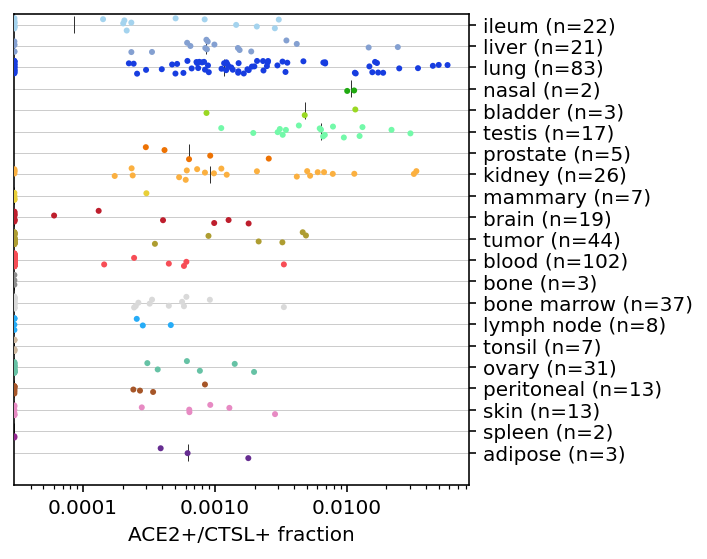

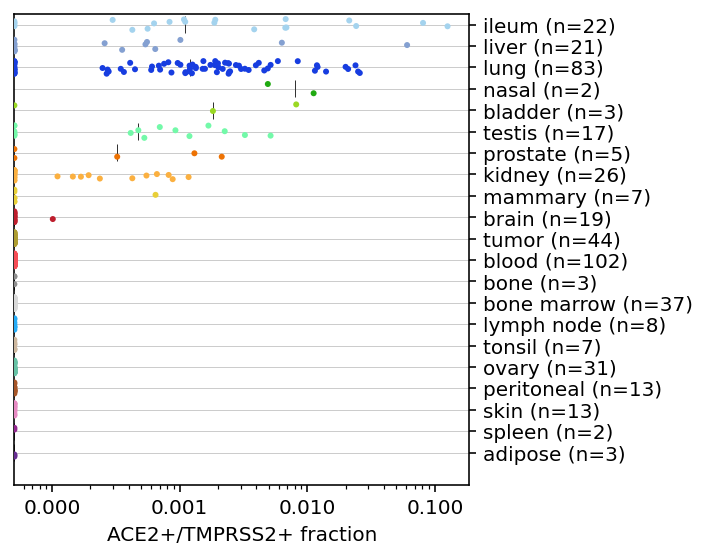

In [34]:
for gene in co_express_genes:
    plot_freq_by_tissue(dp_freqs.copy(), gene, tissue2n, tissue_order, 
                     pseudo_count=dp_freqs[gene][dp_freqs[gene]>0].min(), 
                     xlabel= 'ACE2+/' + gene + '+ fraction') 

## Fisher test stats

In [35]:
def get_gene_pair_stats_df(gene1, gene2, master_df, tissue_order):
    # fisher test stats for ACE2 and TMPRSS2
    
    stats_df = pd.DataFrame(columns=['study', 'sample', 'tissue', 'odds_ratio', 'log_odds_ratio', 'p_value', 'log_p_value', gene1+"_fraction", gene2+'_fraction'])

    for study_sample,sample_df in tqdm(master_df[['study', 'sample', gene1, gene2, 'tissue']].groupby(['study', 'sample'])):
        gene1_vec = sample_df[gene1]>0
        gene2_vec = sample_df[gene2]>0

        num_dp = np.sum(gene1_vec & gene2_vec)
        num_total_cells = len(gene1_vec)    
        odds, lodds, pv, lpv =  fisher_coexp(gene1_vec, gene2_vec)

        d = {'study':study_sample[0] ,
             'sample': study_sample[1],
             'tissue':sample_df.tissue.iloc[0], 
             'odds_ratio':odds, 
             'log_odds_ratio':lodds, 
             'p_value':pv, 
             'log_p_value':lpv,
             'dp_fraction':num_dp/num_total_cells,
             'double_positives':num_dp,
             'num_total_cells':num_total_cells,
             gene1+'_fraction':np.sum(gene1_vec)/num_total_cells, 
             gene2+'_fraction':np.sum(gene2_vec)/num_total_cells,          
            }

        stats_df = stats_df.append(pd.DataFrame([d]))

    stats_df = stats_df[~stats_df['tissue'].isna()].reset_index(drop=True) 
    stats_df = stats_df[~stats_df['tissue'].str.match('tumor')].reset_index(drop=True) 

    # get ordering based on max of each tissue
    stats_df["tissue"] = pd.Categorical(stats_df["tissue"], tissue_order)
    
    stats_df[gene1+'_'+gene2+'_odds_ratio'] = stats_df['odds_ratio']
    stats_df[gene1+'_'+gene2+'_log_p_value'] = -stats_df['log_p_value']
    
    return stats_df.sort_values(['tissue', 'dp_fraction'])

  6%|▌         | 28/468 [00:03<01:12,  6.10it/s]/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
 11%|█▏        | 53/468 [00:07<03:48,  1.81it/s]/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
 13%|█▎        | 60/468 [00:08<01:52,  3.62it/s]/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
 14%|█▎        | 64/468 [00:08<01:26,  4.66it/s]/home/gheimber/.anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: Runti

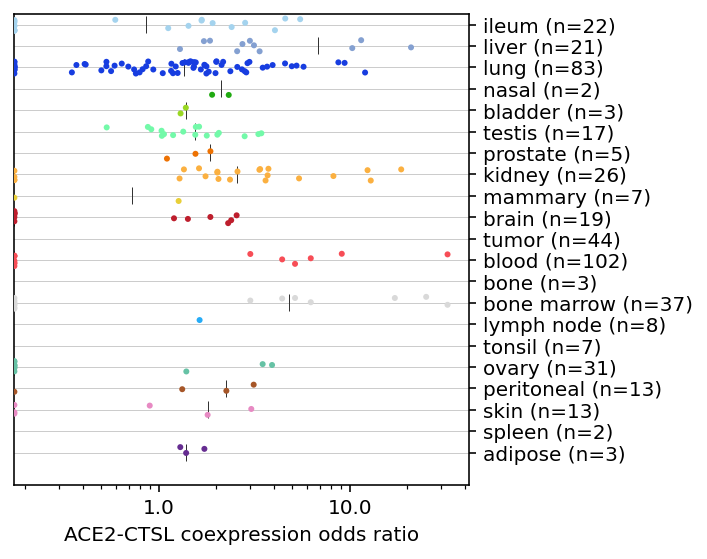

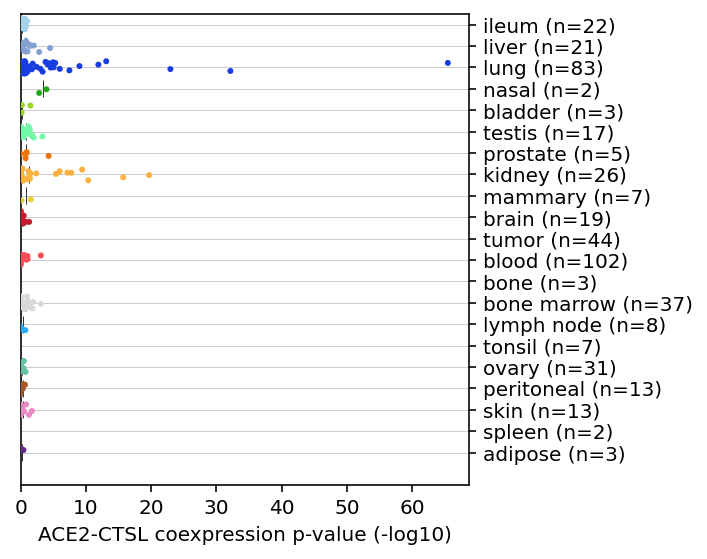

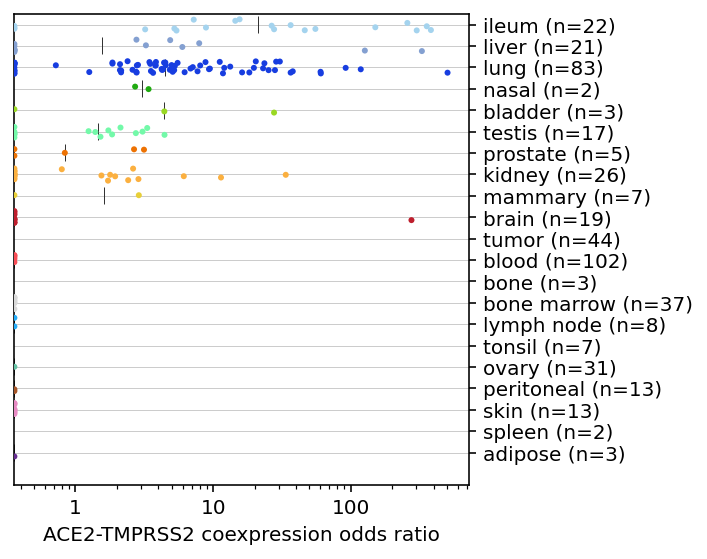

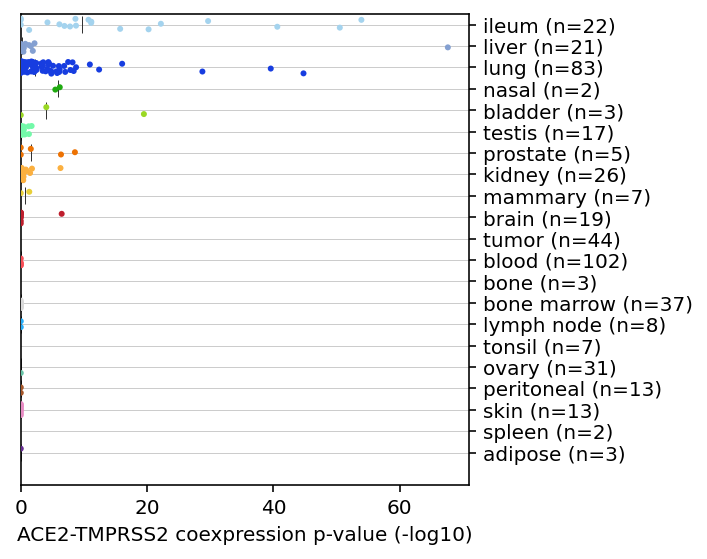

In [36]:
#for gene in co_express_genes:
for gene in ['CTSL', 'TMPRSS2']:
    gene_stats_df = get_gene_pair_stats_df('ACE2', gene, full_df, tissue_order)
    gene_stats_df['tissue'] = pd.Categorical(gene_stats_df['tissue'], ordered=True, categories=tissue_order)
    gene_stats_df = gene_stats_df.sort_values('tissue') 
    
    plot_freq_by_tissue(gene_stats_df.copy(), 'ACE2_' + gene + '_odds_ratio', tissue2n, tissue_order, 
                        pseudo_count=gene_stats_df.odds_ratio[gene_stats_df.odds_ratio>0].min(), 
                        dpi=400, log=True, marker='o', ax=None, 
                        xlabel= 'ACE2-' + gene + ' coexpression odds ratio')
    
    plot_freq_by_tissue(gene_stats_df.copy(), 'ACE2_' + gene + '_log_p_value', tissue2n, tissue_order, 
                        pseudo_count=gene_stats_df.p_value[gene_stats_df.p_value>0].min(), 
                        dpi=400, log=False, marker='o', ax=None, 
                        xlabel= 'ACE2-' + gene + ' coexpression p-value (-log10)') 
    
    #gene_stats_df.to_csv('/home/gheimber/scDB/coronavirus/methods_code/fisher_stats/ACE2_' + gene + '_fisher_stats.csv')    

# coarse cell types

In [16]:
typed_subset = full_df[~full_df['manual_cell_type'].isna()]

### double positive frequency

In [17]:
typed_dp_df = dp_df.merge(typed_subset[['study', 'sample', 'barcode', 'tissue', 'manual_cell_type']], on=['barcode', 'study', 'sample', 'tissue'])
sizes = typed_dp_df.groupby(['study', 'sample', 'tissue', 'manual_cell_type'], observed=True).size().reset_index()[0]
typed_dp_df = typed_dp_df.groupby(['study', 'sample', 'tissue', 'manual_cell_type'], observed=True).mean().reset_index()
typed_dp_df['num_cells'] = sizes
typed_dp_df = typed_dp_df[typed_dp_df.num_cells>100]
typed_dp_df.tissue = typed_dp_df.tissue.to_list()

In [18]:
class_order = typed_dp_df.groupby('manual_cell_type', observed=False).max()
class_order = class_order.sort_values(by='TMPRSS2', ascending=False).reset_index()['manual_cell_type'].to_list()

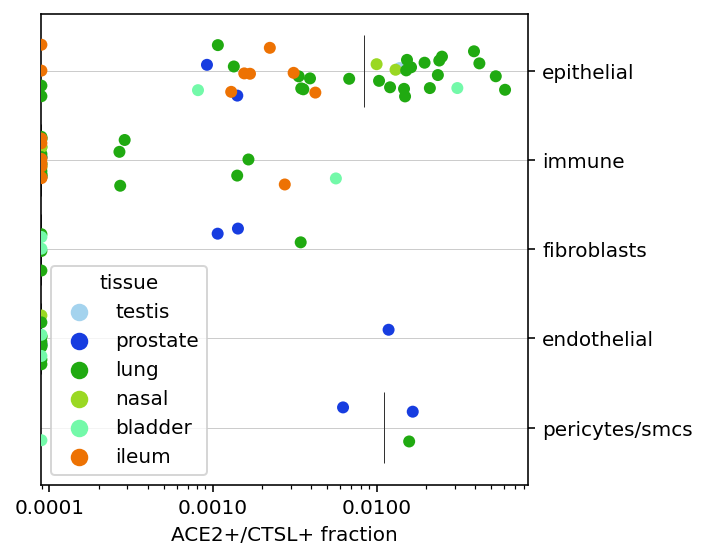

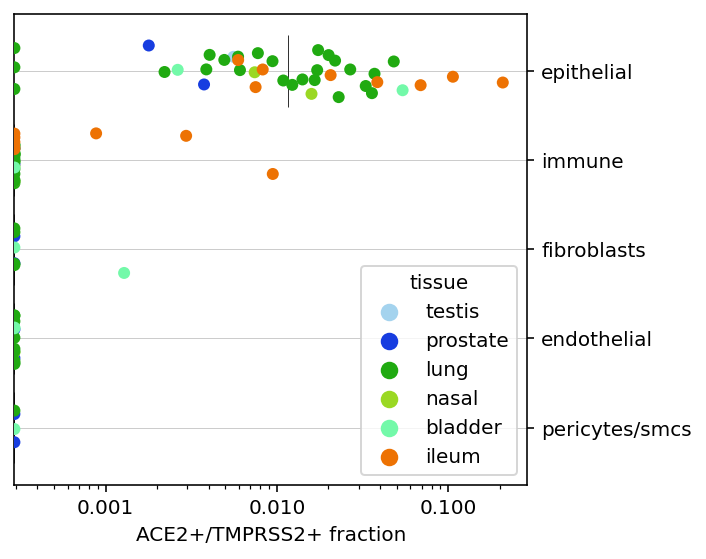

In [19]:
for gene in co_express_genes:
    plot_freq_by_class(typed_dp_df.copy(), gene, class_order, 
                     xlabel= 'ACE2+/' + gene + '+ fraction')    

### single gene broad cell class

In [20]:
single_express_genes = ['CTSL', 'ACE2', 'TMPRSS2']
single_gene_freq = pd.concat((typed_subset[['study', 'sample', 'tissue', 'manual_cell_type']], typed_subset[single_express_genes]>0), axis=1)
sizes = single_gene_freq.groupby(['study', 'sample', 'tissue', 'manual_cell_type'], observed=True).size().reset_index()[0]
single_gene_freq = single_gene_freq.groupby(['study', 'sample', 'tissue', 'manual_cell_type'], observed=True).mean().reset_index()
single_gene_freq['num_cells'] = sizes
single_gene_freq = single_gene_freq[single_gene_freq.num_cells>100]
single_gene_freq.tissue = single_gene_freq.tissue.to_list()

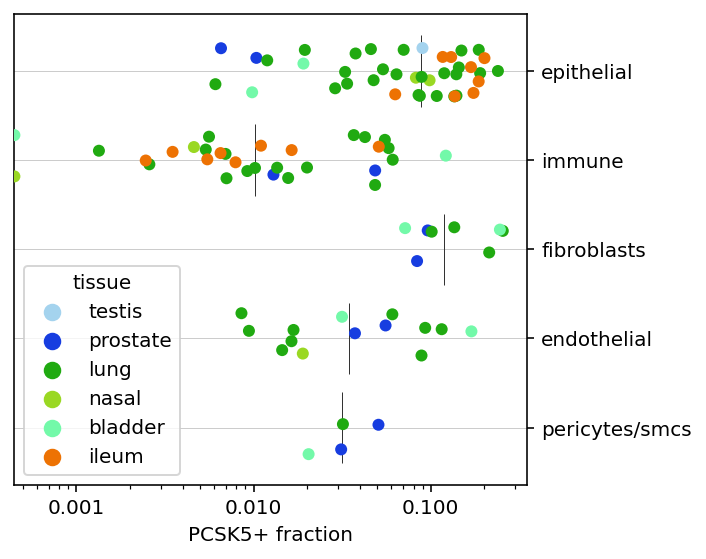

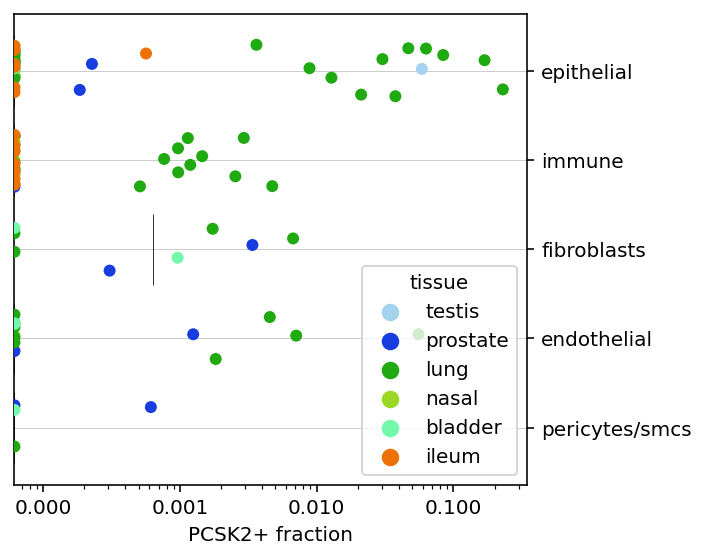

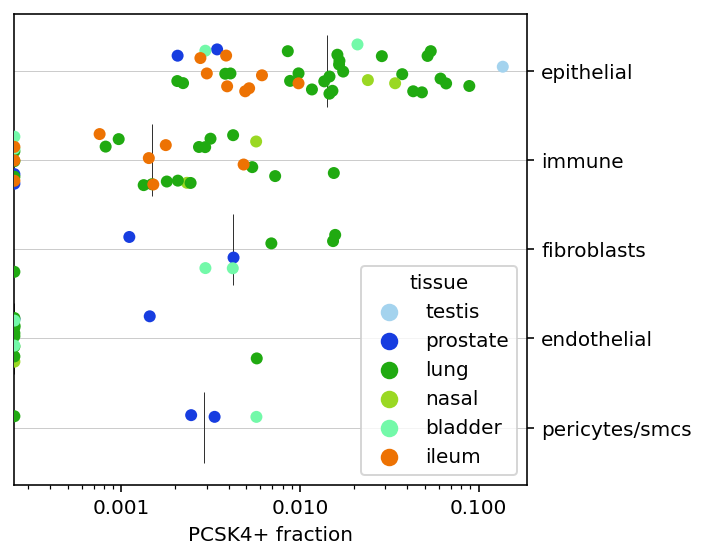

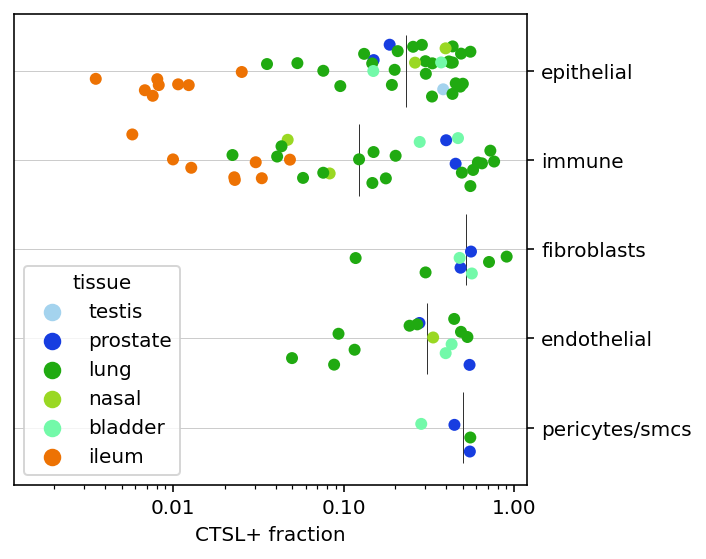

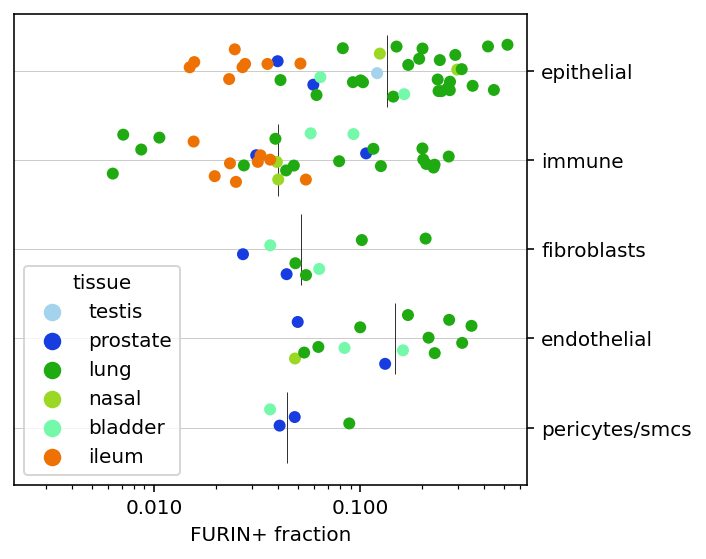

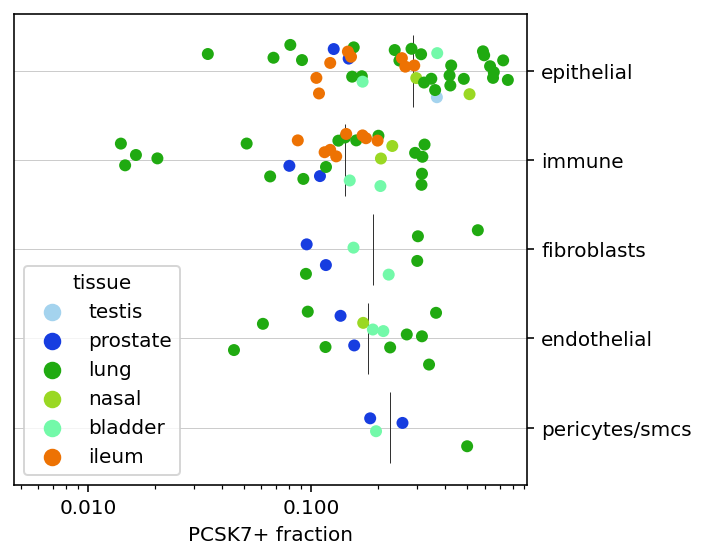

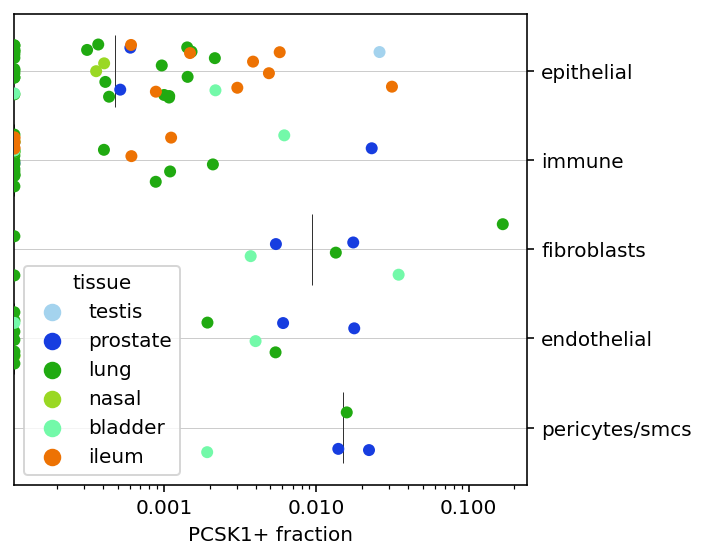

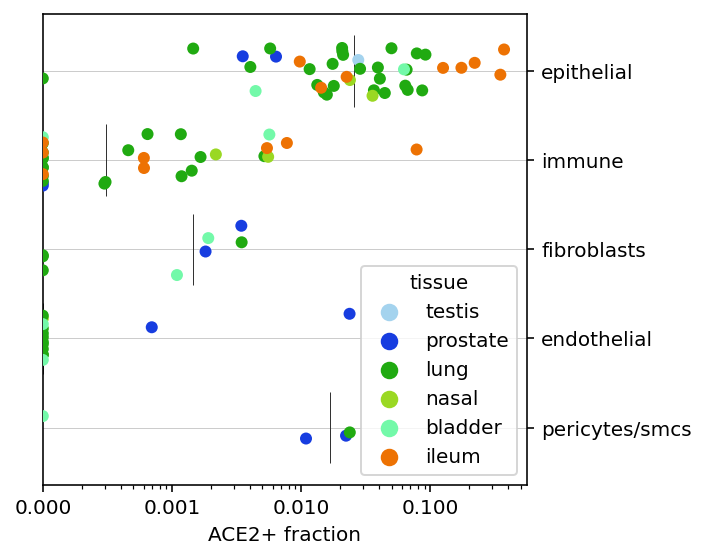

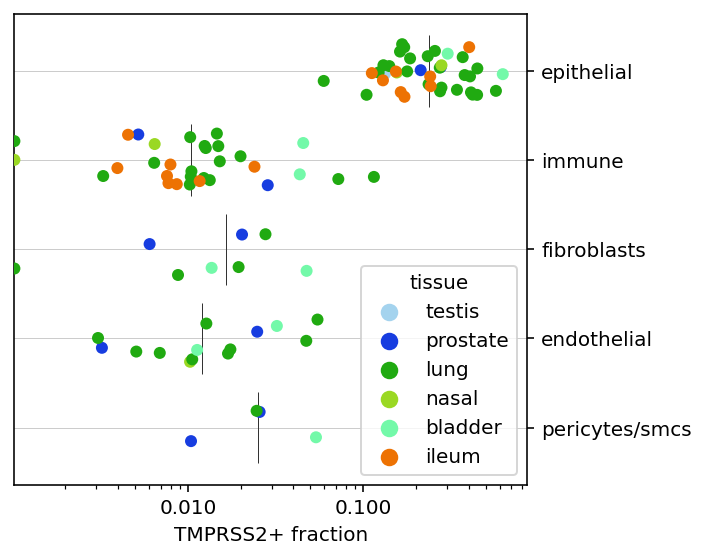

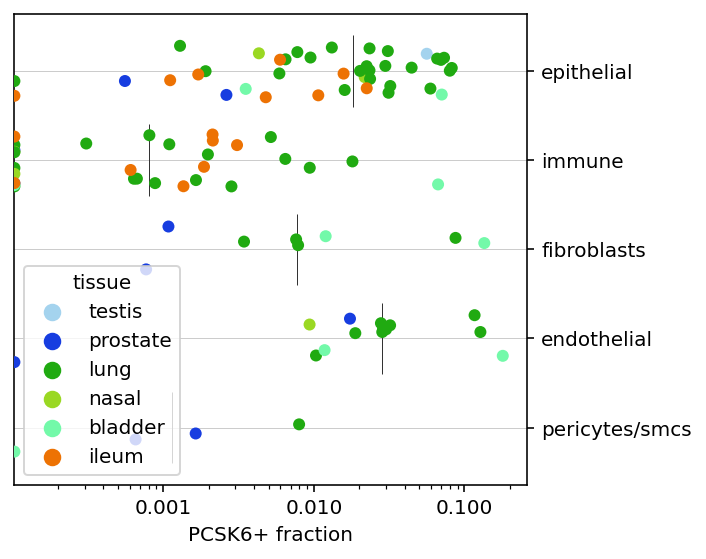

In [21]:
for gene in single_express_genes:
    plot_freq_by_class(single_gene_freq.copy(), gene, class_order, 
                     xlabel= gene + '+ fraction')    
